In [1]:
import os
import numpy as np
#import pickle
%matplotlib inline
from matplotlib import pyplot as plt
#import seaborn as sns
from skimage.filters import sobel_h, sobel_v
from skimage.color import rgb2grey
from skimage.transform import resize
from skimage.filters import threshold_adaptive
from skimage.exposure import rescale_intensity
from utils.utils import *
from utils.iterators import SynthiaIterator, FreiburgIterator, TUMIterator
from utils.associate import associate, read_file_list
import cv2

In [2]:
#All paths are here
#synthia_dataset = '/home/vladimir/external/data/SYNTHIA/SYNTHIA-SEQS-02-SOFTRAIN/'
synthia_dataset = '/home/vladimir/Desktop/SYNTHIA/'
#synthia_val = '/home/vladimir/Desktop/SYNTHIA-SEQS-02-SOFTRAIN/'
synthia_val = '/run/media/vladimir/win_back/data/SYNTHIA/SYNTHIA-SEQS-06-SUMMER/'
tum_dataset = '/home/vladimir/external/data/TUM/'
driving_dataset = '/home/vladimir/Desktop/driving/'
log_dir= '/home/vladimir/Yandex.Disk/train_log/'
#visual_images_dir = '/home/vladimir/valimg/'
val_synthia = '/home/vladimir/external/data/val_seq/'

synthia_size = [187, 225]
big_size = [1496, 1800]

In [3]:
def get_TUM_files(tum_dataset):
    import os
    from utils.associate import associate, read_file_list
    timestamps = []
    for parent, _, files in os.walk(tum_dataset):
        rgb_path = ''
        depth_path = ''
        for fname in files:
            if 'rgb.txt' in fname:
                rgb_path = os.path.join(parent, fname)
            if 'depth.txt' in fname:
                depth_path = os.path.join(parent, fname)
        if not any([rgb_path == '', depth_path == '']):
            timestamps.append((rgb_path, depth_path))
            
    matches = [associate(l[0], l[1], 0, 0.02) for l in 
               [(read_file_list(stamp[0]), read_file_list(stamp[1])) for stamp in timestamps]]
    
    tum_rgb = []
    tum_depth = []
    for i,s in enumerate(timestamps):
        dir_n = os.path.dirname(s[0])
        tum_rgb.append([os.path.join(os.path.join(dir_n, "rgb"), "{0:.6f}".format(s[0]) + ".png") 
                        for s in matches[i]])
        tum_depth.append([os.path.join(os.path.join(dir_n, "depth"), "{0:.6f}".format(s[1]) + ".png") 
                          for s in matches[i]])
    flatten = lambda x: [item for l in x for item in l]
    tum_rgb = flatten(tum_rgb)
    tum_depth = flatten(tum_depth)
    return tum_rgb, tum_depth

In [4]:
driving_list = get_file_list(driving_dataset)
driving_depth = filter_files(driving_list, ['left', 'forwards', 'pfm'])[:600]
driving_rgb =  filter_files(driving_list, ['left', 'forwards', 'webp'])[:600]

In [5]:
synthia_list = get_file_list(synthia_dataset)
synthia_depth = filter_files(synthia_list, ['Stereo_Left', 'Depth', 'png'])
synthia_rgb =  filter_files(synthia_list, ['Stereo_Left','RGB','png'])

In [ ]:
#val_image_s = open_rgb(visual_images_dir + 'synthia_img.png')[None,:,:,:]
#val_gt_s = open_depth_synthia(visual_images_dir + 'synthia_depth.png')[None]
#val_image_d = open_rgb(visual_images_dir + 'driving_img.webp')[None,:,:,:]
#val_gt_d = open_depth_freiburg(visual_images_dir + 'driving_depth.pfm')[None,:,:,:]
val_gt_s = cv2.imread(r'/home/vladimir/MSG-Net/MSGNet-release/testing sets/A/Depth/art.png',cv2.IMREAD_ANYDEPTH)
print(val_gt_s.shape)
idx = np.where(val_gt_s == 0)
val_gt_s_b = cv2.medianBlur(val_gt_s, 17)
val_gt_s[idx] = val_gt_s_b[idx]
val_gt_d = cv2.imread('/home/vladimir/middle/Dolls/disp1.png', cv2.IMREAD_ANYDEPTH)[:360, :440]
idx = np.where(val_gt_d == 0)
val_gt_d_b = cv2.medianBlur(val_gt_d, 19)
val_gt_d[idx] = val_gt_d_b[idx]
plt.matshow(val_gt_s)
plt.matshow(val_gt_d)
val_gt_s = val_gt_s[np.newaxis, ..., np.newaxis]
val_gt_d = val_gt_d[np.newaxis, ..., np.newaxis]

## NN

In [6]:
import tensorflow as tf


In [7]:
from tensorflow.contrib import layers as l

def drop(x, p, is_training=True):
    noise_sh = [1,1,1,x.get_shape().as_list()[3]]
    return l.dropout(x,p, is_training=is_training, noise_shape=noise_sh) 


def conv2d(in_tensor, out_dim, name='conv', kernel_sz=3, act=None, stride=1, bn=False):
    with tf.variable_scope(name):
        if bn:
            norm = l.batch_norm
            l_act=None
        else:
            norm = None
            l_act=act
        out = l.conv2d(in_tensor, 
                       num_outputs=out_dim, 
                       kernel_size=kernel_sz, 
                       stride=stride, 
                       normalizer_fn = norm, 
                       activation_fn=l_act, 
                       padding = 'SAME',
                       normalizer_params={'activation_fn':act})
    return out

def projection_block(in_tensor, out_dim, name='conv', kernel_sz=3, act=None, stride=1, bn=False):
        with tf.variable_scope(name):
            if bn:
                norm = l.batch_norm
                l_act=None
            else:
                norm = None
                l_act=act
            out = l.conv2d(in_tensor, 
                           num_outputs=out_dim, 
                           kernel_size=kernel_sz, 
                           stride=stride, 
                           normalizer_fn = norm, 
                           activation_fn=l_act, 
                           padding = 'SAME',
                           normalizer_params={'activation_fn':act})
            out = l.conv2d(out, 
                           num_outputs=out_dim, 
                           kernel_size=kernel_sz, 
                           stride=stride, 
                           normalizer_fn = norm, 
                           activation_fn=l_act, 
                           padding = 'SAME',
                           normalizer_params={'activation_fn':act})
            proj = l.conv2d(in_tensor, 
                           num_outputs=out_dim, 
                           kernel_size= 1, 
                           stride=stride, 
                           normalizer_fn = norm, 
                           activation_fn=None, 
                           padding = 'SAME',
                           normalizer_params={'activation_fn':None})
        return out + proj
    
    
    
def downscale_block(in_tensor, out_dim, name='conv', kernel_sz=3, act=None, stride=2, bn=False):
    with tf.variable_scope(name):
        if bn:
            norm = l.batch_norm
            l_act=None
        else:
            norm = None
            l_act=act
        out = l.conv2d(in_tensor, 
                       num_outputs=out_dim, 
                       kernel_size=kernel_sz, 
                       stride=stride, 
                       normalizer_fn = norm, 
                       activation_fn=l_act, 
                       padding = 'SAME',
                       normalizer_params={'activation_fn':act})
        out = l.conv2d(out, 
                       num_outputs=out_dim, 
                       kernel_size=kernel_sz, 
                       stride=1, 
                       normalizer_fn = norm, 
                       activation_fn=l_act, 
                       padding = 'SAME',
                       normalizer_params={'activation_fn':act})
        proj = l.conv2d(in_tensor, 
                       num_outputs=out_dim, 
                       kernel_size=2, 
                       stride=stride, 
                       normalizer_fn = norm, 
                       activation_fn=None, 
                       padding = 'SAME',
                       normalizer_params={'activation_fn':None})
    return out + proj

def downscale_pool(in_tensor, out_dim, name='conv', kernel_sz=3, act=None, stride=2, bn=False):
    with tf.variable_scope(name):
        if bn:
            norm = l.batch_norm
            l_act=None
        else:
            norm = None
            l_act=act
        out = l.conv2d(in_tensor, 
                       num_outputs=out_dim, 
                       kernel_size=kernel_sz, 
                       stride=stride, 
                       normalizer_fn = norm, 
                       activation_fn=l_act, 
                       padding = 'SAME',
                       normalizer_params={'activation_fn':act})
        out = l.conv2d(out, 
                       num_outputs=out_dim, 
                       kernel_size=kernel_sz, 
                       stride=1, 
                       normalizer_fn = norm, 
                       activation_fn=l_act, 
                       padding = 'SAME',
                       normalizer_params={'activation_fn':act})
        
        down = l.avg_pool2d(in_tensor, 3, 2, padding='SAME')
        proj = l.conv2d(down, 
                       num_outputs=out_dim, 
                       kernel_size=1, 
                       stride=1, 
                       normalizer_fn = norm, 
                       activation_fn=None, 
                       padding = 'SAME',
                       normalizer_params={'activation_fn':None})
    return out + proj   


def residual_block(in_tensor, out_dim, name='conv', kernel_sz=3, act=None, stride=1, bn=False):
        with tf.variable_scope(name):
            if bn:
                norm = l.batch_norm
                l_act=None
            else:
                norm = None
                l_act=act
            out = l.conv2d(in_tensor, 
                           num_outputs=out_dim, 
                           kernel_size=kernel_sz, 
                           stride=stride, 
                           normalizer_fn = norm, 
                           activation_fn=l_act, 
                           padding = 'SAME',
                           normalizer_params={'activation_fn':act})
            out = l.conv2d(out, 
                           num_outputs=out_dim, 
                           kernel_size=kernel_sz, 
                           stride=stride, 
                           normalizer_fn = norm, 
                           activation_fn=l_act, 
                           padding = 'SAME',
                           normalizer_params={'activation_fn':act})
        return out + in_tensor


def deconv2d(in_tensor, out_dim,  name='transposed_conv', kernel_sz=3, act=None, stride=1, bn=False):
    with tf.variable_scope(name):
        if bn:
            norm = l.batch_norm
            l_act=None
        else:
            norm = None
            l_act=act
        out = l.conv2d_transpose(in_tensor, 
                       num_outputs=out_dim, 
                       kernel_size=kernel_sz, 
                       stride=stride, 
                       normalizer_fn = norm, 
                       activation_fn=l_act, 
                       padding = 'SAME',
                       normalizer_params={'activation_fn':act})

    return out




def dilated2d(in_tensor, out_dim,  name='dilated_conv', kernel_sz=3, act=None, dilation=1, bn=False):
    with tf.variable_scope(name):
        if bn:
            norm = l.batch_norm
            l_act=None
        else:
            norm = None
            l_act=act
        out = l.conv2d(in_tensor, 
                       num_outputs=out_dim, 
                       kernel_size=kernel_sz, 
                       rate=dilation, 
                       normalizer_fn = norm, 
                       activation_fn=l_act, 
                       padding = 'SAME',
                       normalizer_params={'activation_fn':act})
    return out

def upproject(in_tensor, out_dim,  name='uproj_conv', kernel_sz=4, stride=2):
    return deconv2d(in_tensor, out_dim, name, kernel_sz ,act=None, stride=stride, bn=False)

def prelu(_x):
    alphas = tf.get_variable('alpha', _x.get_shape()[-1],
                       initializer=tf.constant_initializer(0.1),
                        dtype=tf.float32)
    pos = tf.nn.relu(_x)
    neg = alphas * (_x - abs(_x)) * 0.5

    return pos + neg

In [8]:
tf.reset_default_graph()

target = tf.placeholder(tf.float32, shape=(None,None,None, 1))
d_flg = tf.placeholder(tf.bool)
p = 0.8
eps = tf.constant(1e-6)

In [52]:
def preprocess(d_tensor, size_small, size_big):
    
    d_log = (d_tensor - tf.reduce_min(d_tensor)) / (tf.reduce_max(d_tensor)- 
                                                    tf.reduce_min(d_tensor))
    d_log = d_log + tf.constant(1.)
    d_small = tf.image.resize_images(d_log, size_small, method=tf.image.ResizeMethod.AREA)
    d_upsampled = tf.image.resize_images(d_small, size_big, method=tf.image.ResizeMethod.BILINEAR)
    #ground_truth = tf.image.resize_images(d_log, size_big, method=tf.image.ResizeMethod.BILINEAR)
    ground_truth = d_log
    
    return ground_truth, d_small, d_upsampled

In [53]:
y_true, d_input, interpolated = preprocess(target,  synthia_size, big_size)
net = {}

In [54]:
use_bn = False
base_filters = 32

In [55]:

net['gate'] = d_input
with tf.variable_scope('G_Depth'):
    net['conv1'] = conv2d(net['gate'], base_filters, 'convolution_1', kernel_sz=3, stride=1, act=tf.nn.elu)
    net['conv2'] = projection_block(net['conv1'], base_filters*2, 'convolution_2', kernel_sz=3, act=tf.nn.elu)
    net['drop1'] = drop(net['conv2'], p, is_training=d_flg)
    net['conv3'] = residual_block(net['drop1'], base_filters*2, 'convolution_3', kernel_sz=3, act=tf.nn.elu)
    net['conv4'] = residual_block(net['conv3'], base_filters*2, 'convolution_4', kernel_sz=3, act=tf.nn.elu)
    net['drop2'] = drop(net['conv4'], p, is_training=d_flg)
    net['conv5'] = residual_block(net['drop2'], base_filters*2, 'convolution_5', kernel_sz=3, act=tf.nn.elu)
    net['conv6'] = residual_block(net['conv5'], base_filters*2, 'convolution_6', kernel_sz=3, act=tf.nn.elu)
    net['drop3'] = drop(net['conv6'], p, is_training=d_flg)
    net['conv7'] = conv2d(net['drop3'], base_filters*4, 'upconv_1',  stride=1, kernel_sz=3,act=tf.nn.elu)
    net['uconv1'] = tf.depth_to_space(net['conv7'], 2)
    net['conv8'] = conv2d(net['uconv1'], base_filters*2,'upconv_2',  stride=1, kernel_sz=3,act=tf.nn.elu)
    net['uconv2'] = tf.depth_to_space(net['conv8'], 2)
    net['conv9'] = deconv2d(net['uconv2'], base_filters,'upconv_3',  stride=1, kernel_sz=3,act=tf.nn.elu)
    net['uconv3'] = tf.depth_to_space(net['conv9'], 2)
    net['conv_out'] = conv2d(net['uconv3'], 1, 'convolution_out', kernel_sz=3, act=None, bn=False)
G_output = net['conv_out'] + interpolated

In [27]:
from vgg.VGG16 import VGG16
vgg_model_true = VGG16(vgg16_npy_path='/home/vladimir/backup/Master/vgg/vgg16.npy')
vgg_model_gen = VGG16(vgg16_npy_path='/home/vladimir/backup/Master/vgg/vgg16.npy')

npy file loaded
npy file loaded


In [28]:
with tf.variable_scope('loss'):
    #vgg loss
    #exp_out = tf.exp(G_output)
    #exp_true = tf.exp(y_true)
    exp_out = G_output
    exp_true = y_true
    y_true_normalized = (exp_true - tf.reduce_min(exp_true))/(tf.reduce_max(exp_true) 
                                                              - tf.reduce_min(exp_true))
    y_true_3ch = tf.concat([y_true_normalized]*3,3)
    
    gen_normalized = (exp_out - tf.reduce_min(exp_out))/(tf.reduce_max(exp_out) 
                                                         - tf.reduce_min(exp_out))
    gen_normalized = (exp_out - tf.reduce_min(exp_out))/(tf.reduce_max(exp_out) 
                                                         - tf.reduce_min(exp_out))
    generated_3ch = tf.concat([gen_normalized]*3, 3)
    
    vgg_model_true.build(y_true_3ch)
    true_features = vgg_model_true.conv3_1
    vgg_model_gen.build(generated_3ch)
    gen_features = vgg_model_gen.conv3_1
    VGG_loss = tf.reduce_mean(tf.square(true_features - gen_features))

    #generator_loss
    tv_loss = tf.reduce_mean(tf.square(G_output[:, :-1, :, :] - G_output[:, 1:, :, :])) + \
              tf.reduce_mean(tf.square(G_output[:, :, :-1, :] - G_output[:, :, 1:, :]))
    #G_loss = tf.reduce_mean(tf.square(y_true - G_output)) 
    square_loss = tf.reduce_mean(tf.square(y_true - G_output))
    G_loss = square_loss + 5e-5*VGG_loss + 2e-6*tv_loss
    #G_loss = tf.reduce_mean(tf.square(y_true - G_output))
    #GC_loss = tf.reduce_mean(tf.abs(tf.log(GC_output  + eps) - log_true))

build model started
build model finished: 0s
build model started
build model finished: 0s


In [ ]:
with tf.variable_scope('opt'):
    #optimizers
    all_params = tf.trainable_variables()
    first_stage = [p for p in all_params if 'G_Depth' in p.name]
    lr = tf.placeholder(dtype=tf.float32)
    train_G = tf.train.AdamOptimizer(lr).minimize(G_loss, var_list = first_stage)

 

In [ ]:
with tf.variable_scope('summaries'):
    loss = tf.summary.scalar('loss', G_loss)
    mae = tf.reduce_mean(tf.abs(G_output-y_true)/(y_true + eps))
    rmse = tf.sqrt(tf.reduce_mean(tf.square(G_output-y_true)))
    mae_summary = tf.summary.scalar('MAE', mae)
    in_summary = tf.summary.image('input', d_input , max_outputs=1)
    out_summary = tf.summary.image('output',G_output, max_outputs=1)
    gt_summary = tf.summary.image('gt_depth', y_true, max_outputs=1)
    all_summaries = tf.summary.merge([mae_summary, in_summary, out_summary, loss])

In [ ]:

log_prefix = '/home/vladimir/tflog/sr_fine_2'

In [ ]:

sess = tf.InteractiveSession()
ground_truths = tf.summary.FileWriter(logdir=os.path.join(log_prefix,'gt','s'))
ground_truthd = tf.summary.FileWriter(logdir=os.path.join(log_prefix, 'gt','d'))
writer_grads = tf.summary.FileWriter(logdir=os.path.join(log_prefix,'grad','s'))
writer_gradd = tf.summary.FileWriter(logdir=os.path.join(log_prefix,'grad','d'))
sess.run(tf.global_variables_initializer())

In [ ]:
from tqdm import tqdm

In [ ]:

batch_size=10
epsi = 1e-6
batch_size = 5
d_rounds = 1
epochs = 35
n_batches= len(synthia_depth)/batch_size
ground_truths.add_summary(gt_summary.eval({target:val_gt_s}))
ground_truthd.add_summary(gt_summary.eval({target:val_gt_d}))
i = 0
rate =  [1e-4]*30 + [1e-5]*30 
saver = tf.train.Saver()
for e in range(epochs):
    try:
        val_loss = 0
        val_b = len(driving_rgb)/batch_size
        batch_it = tqdm(FreiburgIterator(driving_depth, 
                                        batchsize=batch_size, 
                                        shuffle=True, 
                                        buffer_size = 70), 
                        total=val_b, 
                        leave=False)

        for b in batch_it:
            xb = b[0]

            ll = sess.run(mae, feed_dict={target:xb, d_flg:False,lr:0})
            val_loss += ll
        print("epoch {0} val loss {1}".format(e - 1, val_loss/val_b))
        
        
        mse_loss = 0
        batch_it = tqdm(SynthiaIterator(synthia_depth, 
                                        batchsize=batch_size, 
                                        shuffle=True, 
                                        buffer_size = 70), 
                        total=n_batches, 
                        leave=False)

        for b in batch_it:
            xb = b[0]
            aug = np.random.choice([0, 1])
            if aug == 1:
                xb = xb[:,:,::-1,:]
            _, ll = sess.run([train_G, G_loss], feed_dict={target:xb, d_flg:True, lr:rate[e]})
            mse_loss += ll
            if (i + 1)%10 == 0:
                sum_grad = all_summaries.eval({target:val_gt_s, d_flg:False})
                writer_grads.add_summary(sum_grad, i)
                sum_grad = all_summaries.eval({target:val_gt_d, d_flg:False})
                writer_gradd.add_summary(sum_grad, i)
            i += 1
            if (i+1)%100 == 0 :
                saver.save(sess, os.path.join(log_prefix,'model.ckpt'))
        print("epoch {0} train loss {1}".format(e, mse_loss/n_batches))
        
        
    except Exception as e:
        batch_it.iterable.stop()
        raise e
        break 
# save model after training
sess.close()

### Little blog

In [57]:
sess = tf.InteractiveSession()   
restorer = tf.train.Saver()
restorer.restore(sess, tf.train.latest_checkpoint('/home/vladimir/tflog/sr_fine/'))




* Vanilla: dropout 0,7 standart convs only interpolation  1.15/0.38 at 7k iters
* residual and projection blocks in both parts 1/0.41 at 7k iters
* residual blocks in contracting part on grad + uni 1.02/0.4 at 7k
* vanilla w/image 0.9/0.35 at 6k it
* vanilla w grad training and img 0.57/0.33 at 4k
* vanilla w grad training dropout 0.9 0.67/0.41 at 4k
* vanilla no image vgg31 dropout 0.7 no grad 0.7 best
* vanilla log input log out  loss/mae exp sigmoid out 0.26 /0.5 uni at 4k iters
* vanilla ,log input log out , mae exp, linear out 0.33 /0.4 uni at 4k iters
* vanilla, oracle mean substr, (logy - pred)^2 loss, linear out 0.38,0.39 uni at 2.5k
* vanilla, patial mean, vgg31 exp loss, linear out, mae goes up but found objects
* vanilla, partial mean, vgg31 + square loss, linear out, dropout p=0,7, 0.45/0.45 uni but vey good images
* vanilla, grad input, partial mean, vgg21 + square loss, linear out, dropout p=0,6 0.45/0.38 at 5200
* vanilla, image+uni 0.1, partial mean, vgg21 + square loss, linear out, dropout p=0,6 fail
* vanilla, no bn sparse uni train 
* additional scale residual 0.29/0.19 on grad training
* sum instead of cncat const worse

### Middlebury

In [ ]:
def load_pfm(fname):
    import re
    color = None
    width = None
    height = None
    scale = None
    endian = None
    with open(fname, mode='rb') as file:
        header = file.readline().rstrip().decode('ascii')
        if header == 'PF':
            color = True    
        elif header == 'Pf':
            color = False
        else:
            raise Exception('Not a PFM file.')
        dim_match = re.match(r'^(\d+)\s(\d+)\s$', file.readline().decode('ascii'))
        if dim_match:
            width, height = map(int, dim_match.groups())
        else:
            raise Exception('Malformed PFM header.')
        scale = float(file.readline().rstrip().decode('ascii'))
        if scale < 0: # little-endian
            endian = '<'
            scale = -scale
        else:
            endian = '>' # big-endian
        data = np.fromfile(file, endian + 'f')
        shape = (height, width, 3) if color else (height, width)
        return np.reshape(data, shape)[::-1, :], scale
    
def open_middlebury_disp(fname):
    d, _ = load_pfm(fname)
    mask = np.isinf(d)
    min_d = d.min()
    max_d = d[np.logical_not(mask)].max()
    d = (d - min_d) / (max_d - min_d) * 255
    d[mask] = np.zeros_like(d)[mask]
    idx = np.where(d == 0)
    d_b = cv2.medianBlur(d.astype(np.uint8), 155)
    d[idx] = d_b[idx]
    d = cv2.resize(d, (2780, 1920))
    d = d.astype(np.float32) * (max_d - min_d) + min_d
    return d

d = open_middlebury_disp('/home/vladimir/middle/Adirondack-perfect/disp0.pfm')
plt.matshow(d)

In [ ]:
test = ['Art', 'Books', 'Reindeer', 'Laundry', 'Dolls', 'Moebius']
middlebury_path = '/home/vladimir/middle/'
dirs = [os.path.join(middlebury_path, dirn) for dirn in os.listdir(middlebury_path) if dirn not in test]
middelbury_fnames = [os.path.join(dirn, fname) for dirn in dirs for fname in os.listdir(dirn) if 'disp0.pfm' in fname]
middlebury_train = np.zeros((len(middelbury_fnames), 1920, 2780, 1), dtype=np.float32)
for i in range(len(middelbury_fnames)):
    middlebury_train[i,...] = open_middlebury_disp(middelbury_fnames[i])[..., np.newaxis]

In [ ]:
def get_batch_middlebury(X, crop_sz=(360, 440), batch_sz=5):
    idx = np.random.choice(np.arange(len(X)), size=batch_sz, replace=False)
    x_slice = X[idx]
    row = np.random.randint(0, x_slice.shape[1] - crop_sz[0])
    col = np.random.randint(0, x_slice.shape[2] - crop_sz[1])
    x_slice = x_slice[:, row:row + crop_sz[0], col:col + crop_sz[1], :]
    return x_slice

for i in range(5):
    xb = get_batch_middlebury(middlebury_train)
    print(xb.shape)

In [ ]:
train_loss = []
n_iters = 10000
rate =  [1e-4]*3 + [1e-5]*7 
for i in range(n_iters):
    xb = get_batch_middlebury(middlebury_train)
    aug = np.random.choice([0, 1])
    if aug == 1:
        xb = xb[:,:,::-1,:]
    _, l = sess.run([train_G, G_loss], feed_dict={target:xb, d_flg:True, lr:rate[int((i / 1000))]})
    train_loss.append(l)
    if (i + 1)%10 == 0:
        sum_grad = all_summaries.eval({target:val_gt_s, d_flg:False})
        writer_grads.add_summary(sum_grad, i)
        sum_grad = all_summaries.eval({target:val_gt_d, d_flg:False})
        writer_gradd.add_summary(sum_grad, i)
    if (i+1)%1000 == 0 :
        saver.save(sess, os.path.join(log_prefix,'model.ckpt'))
print("epoch {0} train loss {1}".format(e, np.mean(train_loss)))

In [18]:
import cv2
import imageio

data = '/home/vladimir/middle/conesF/disp2.pgm'
def to_show(img, to_colormap=True):
    import seaborn as sns
    
    if to_colormap:
        cmap = sns.cubehelix_palette(10, light=1, as_cmap=True,reverse=True)
        norm = plt.Normalize(vmin=img.min(), vmax=img.max())
        img = cmap(norm(img))[:,:,:-1]
    #result = resize(img, (int(round(img.shape[0]/8)), int(round(img.shape[1]/8))), preserve_range=True)
    result = img
    return result

In [19]:
def read_pgm(data):
    """Return a raster of integers from a PGM as a list of lists."""
    with open(data, mode='rb') as pgmf:
        assert pgmf.readline().decode('ascii')== 'P5\n'
        (width, height) = [int(i) for i in pgmf.readline().decode('ascii').split()]
        depth = int(pgmf.readline())
        assert depth <= 255

        raster = []
        for y in range(height):
            row = []
            for y in range(width):
                row.append(ord(pgmf.read(1)))
            raster.append(row)
        return raster

In [20]:
def norm_max(img):
    return (img - img.min())/(img.max() - img.min())

In [21]:
def rmse(x, y):
    return np.sqrt(((x - y)*(x - y)).mean())

In [63]:
from sklearn.metrics import mean_squared_error
from skimage.measure import compare_ssim, compare_mse
from scipy.io import loadmat
from time import time
import imageio
disp = np.asarray(read_pgm(data), dtype=np.uint8)[:1496, :1800]
print(disp.shape)
idx = np.where(disp == 0)
disp_b = cv2.medianBlur(disp, 11)
disp[idx] = disp_b[idx]
disp = disp.astype(np.float64)

inters = {'linear': cv2.INTER_LINEAR,  'cubic':cv2.INTER_CUBIC, 'lancoz':cv2.INTER_LANCZOS4, 
          'nearest': cv2.INTER_NEAREST}
times = []
disp_small = cv2.resize(disp, tuple(synthia_size[::-1]), interpolation=cv2.INTER_AREA)
for name ,inter in inters.items():
    start = time()
    out = sess.run(G_output, feed_dict={target:disp[None,:,:,None], d_flg:False})[0,:,:,0].astype(float)
    times.append(time() - start)
    trad_t = time()
    int_trad = cv2.resize(disp_small, tuple(big_size[::-1]), interpolation=inter)
    trad_t = time() - trad_t
    out = norm_max(out)
    int_trad = norm_max(int_trad)
    d_n = norm_max(disp)
    print('{} ssim {} rmse {} time {}'.format(name, compare_ssim(int_trad, d_n), rmse(int_trad * 255, d_n * 255), 
                                              trad_t))
print('our ssim', compare_ssim(out, d_n), 'our rmse', rmse(out * 255, d_n * 255))
print('mean time {}'.format(np.mean(times)))

(1496, 1800)
lancoz ssim 0.9439730198661568 rmse 15.608999288681554 time 0.004325151443481445
cubic ssim 0.9437389050734852 rmse 15.75356353852987 time 0.005725383758544922
linear ssim 0.9645148839096646 rmse 8.31542587192037 time 0.0024454593658447266
nearest ssim 0.9595349277470512 rmse 9.200833572880772 time 0.0040013790130615234
our ssim 0.941595342051 our rmse 12.6856248906
mean time 0.10450947284698486


In [59]:

res = norm_max(int_trad.astype(np.float64)) 
disp = norm_max(disp) 
ss = compare_ssim(res, disp)
mse = rmse(res * 255, disp * 255)
print(ss)
print(mse)

0.959534927747
9.20083357288


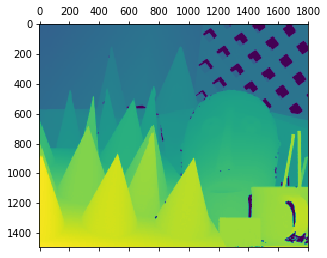

In [60]:
plt.matshow(int_trad) 

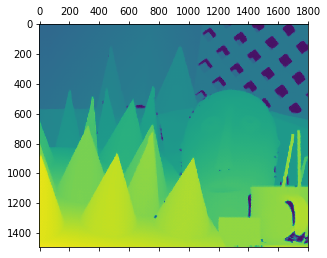

In [61]:
plt.matshow(out)

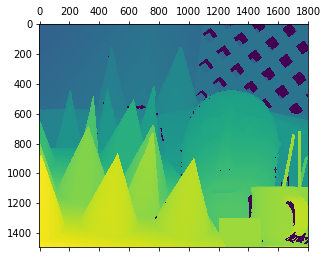

In [62]:
plt.matshow(disp)

In [ ]:
mins = []
maxes = []

for d in synthia_depth:
    mins.append(np.min(open_depth_synthia(d)))
    maxes.append(np.max(open_depth_synthia(d)))
    

In [ ]:
np.max(maxes)

In [ ]:
np.min(mins)

In [ ]:
np.log(0.1)

In [ ]:
print(cubic.shape)

In [ ]:
print(disp.shape)

In [ ]:
d.shape

In [ ]:
inters.items()

In [ ]:
type(disp)